# Flaml (Fast and Lightweight AutoML) Time Series Forecast Demo

Restart runtime after installation (ignore errors).

In [1]:
!pip3 install "flaml[ts_forecast]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 206 kB 4.8 MB/s 
     |████████████████████████████████| 2.0 MB 43.9 MB/s 
     |████████████████████████████████| 786 kB 39.6 MB/s 
     |████████████████████████████████| 172 kB 43.9 MB/s 
     |████████████████████████████████| 208 kB 42.3 MB/s 
     |████████████████████████████████| 70 kB 4.9 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
  Attempting uninstall: holidays
    Found existing installation: holidays 0.15
    Uninstalling holidays-0.15:
      Successfully uninstalled holidays-0.15


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from flaml import AutoML

### Import dataset

In [3]:
df = sns.load_dataset('flights')
df

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


### Preprocessing

The first column must to be continuous ```datetime64``` values

In [4]:
t = pd.to_datetime(df.year.astype('str') + '-' + df.month.astype('str'), format='%Y-%b')
df.insert(0, 'timestamp', t)
df = df.drop(['year', 'month'], axis=1)
df

,timestamp,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


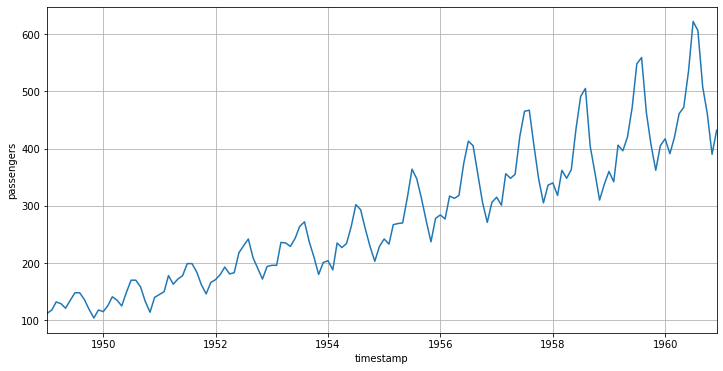

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='timestamp', y='passengers')
plt.xlim([df.timestamp[0], df.timestamp[df.index.size-1]])
plt.grid(True)
plt.show()

### Train model

Use 20% data as test dataset

In [6]:
split = 0.2
split_index = int(df.index.size*(1-split))

train, test = df[:split_index], df[split_index:].drop(['passengers'], axis=1)

In [7]:
reg = AutoML()
reg.fit(dataframe=train, label='passengers', task='ts_forecast', split_type='time', estimator_list=['prophet', 'arima', 'sarimax'], period=36, time_budget=120)

[flaml.automl: 09-10 13:06:33] {2600} INFO - task = ts_forecast
INFO:flaml.automl:task = ts_forecast
[flaml.automl: 09-10 13:06:33] {2602} INFO - Data split method: time
INFO:flaml.automl:Data split method: time
[flaml.automl: 09-10 13:06:33] {2605} INFO - Evaluation method: cv
INFO:flaml.automl:Evaluation method: cv
[flaml.automl: 09-10 13:06:33] {1499} INFO - Using nsplits=2 due to data size limit.
INFO:flaml.automl:Using nsplits=2 due to data size limit.
[flaml.automl: 09-10 13:06:33] {2727} INFO - Minimizing error metric: mape
INFO:flaml.automl:Minimizing error metric: mape
[flaml.automl: 09-10 13:06:33] {2869} INFO - List of ML learners in AutoML Run: ['prophet', 'arima', 'sarimax']
INFO:flaml.automl:List of ML learners in AutoML Run: ['prophet', 'arima', 'sarimax']
[flaml.automl: 09-10 13:06:33] {3174} INFO - iteration 0, current learner prophet
INFO:flaml.automl:iteration 0, current learner prophet
DEBUG:cmdstanpy:input tempfile: /tmp/tmph673bf9l/t3ps50yw.json
DEBUG:cmdstanpy:in

In [8]:
print('Best ML leaner:', reg.best_estimator)
print('Best hyperparmeter config:', reg.best_config)

Best ML leaner: prophet
Best hyperparmeter config: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 9.907664630875948, 'holidays_prior_scale': 6.372933414610401, 'seasonality_mode': 'multiplicative'}


### Predict values

If the model is *Prophet*, pass a DataFrame with timestamps to the ```predict()``` method.

If the model is *ARIMA* or *SARIMAX*, pass a number (number of future values to be predicted). 

In [9]:
if reg.best_estimator == 'prophet':
  predicted = reg.predict(test)  # prophet
else:
  reg.predict(test.index.size)  # arima/sarimax

predicted.index = test.index  # use test DataFrame index
predicted

115    482.368204
116    426.742303
117    370.780512
118    322.563897
119    366.312654
120    374.160663
121    364.518137
122    413.025364
123    402.608510
124    412.622148
125    472.645395
126    538.560808
127    519.221231
128    463.214904
129    401.196508
130    345.759114
131    396.012971
132    404.438976
133    397.754629
134    455.982332
135    440.926574
136    441.515191
137    517.512961
138    562.797810
139    567.638281
140    493.049342
141    430.137228
142    380.693505
143    424.395999
Name: yhat, dtype: float64

In [10]:
from sklearn.metrics import mean_absolute_error

print('Prection MAE:', mean_absolute_error(df[split_index:].passengers, predicted).round(3))

Prection MAE: 18.016


### Predict future new values

In [11]:
new_test = pd.DataFrame({'timestamp': pd.date_range(start='1960-12-01', end='1963-12-01', freq='MS')})

if reg.best_estimator == 'prophet':
  new_predicted = reg.predict(new_test)
else:
  reg.predict(new_test.index.size)

new_predicted

0     424.395999
1     432.758429
2     412.490051
3     485.529253
4     470.319346
5     474.332183
6     551.417032
7     608.888930
8     604.633534
9     529.513970
10    460.647564
11    403.832408
12    453.969745
13    462.917445
14    445.792864
15    514.465635
16    499.421719
17    507.345795
18    584.988420
19    655.766810
20    641.136902
21    566.227905
22    491.166365
23    426.578094
24    483.657127
25    493.209977
26    479.721661
27    542.773395
28    528.246737
29    540.565400
30    618.242354
31    703.420008
32    677.134706
33    603.191578
34    521.684510
35    448.940560
36    513.471422
Name: yhat, dtype: float64

### Visualization

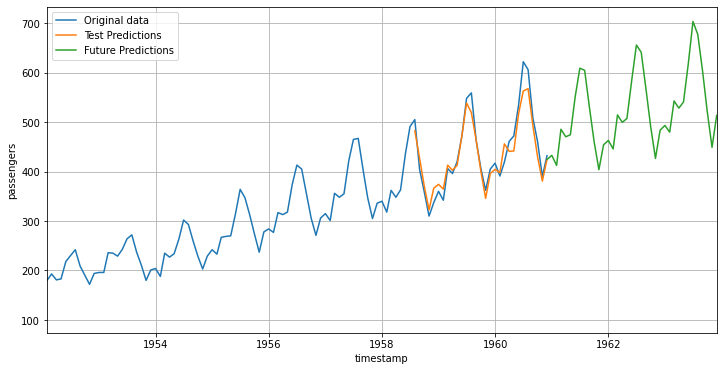

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='timestamp', y='passengers', label='Original data')
sns.lineplot(x=test.timestamp, y=predicted, label='Test Predictions')
sns.lineplot(x=new_test.timestamp, y=new_predicted, label='Future Predictions')
plt.xlim([df.timestamp[new_test.index.size], new_test.timestamp[new_test.index.size-1]])
plt.grid(True)
plt.show()